# Multi-Domain Recommendation System: Movies & Books

## Project Overview
This project aims to build a recommendation system that can suggest items to users based on different methodologies. We utilize datasets for both **Movies** (MovieLens/TMDB) and **Books** to explore cross-domain analysis and recommendation techniques.

## Methodologies Implemented
1.  **Exploratory Data Analysis (EDA)**: Understanding genre distributions and cross-domain intersections.
2.  **Content-Based Filtering**: Recommending items similar to those a user likes based on item attributes (plot summaries) using TF-IDF.
3.  **Collaborative Filtering**: Recommending items based on user interaction patterns (User-Item Matrix) using Memory-Based approaches.
4.  **Matrix Factorization (SVD)**: Using Singular Value Decomposition for dimensionality reduction.
5.  **Matrix Factorization (SGD)**: Using Stochastic Gradient Descent to minimize prediction error.
6.  **Matrix Factorization (ALS)**: Using Alternating Least Squares for optimization.
7.  **Cross-Domain Recommendations**: Using the models above (trained on Movies) to recommend Books by bridging User Genre Preferences.

## 1. Data Loading and Preparation
We load the necessary datasets:
*   `movies_metadata.csv`: Details about movies (title, genres, overview).\n
*   `ratings_small.csv`: User ratings for movies.
*   `books.csv`: Dataset of books with genres.
*   `links_small.csv`: Mapping file to link MovieLens IDs (used in ratings) with TMDB IDs (used in metadata).

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from collections import Counter

# Load Datasets
print("Loading datasets...")
try:
    movies = pd.read_csv('E:\\Projects\\ML\\ML-Project\\movies_metadata.csv', low_memory=False)
    ratings = pd.read_csv('E:\\Projects\\ML\\ML-Project\\ratings_small.csv')
    books = pd.read_csv('E:\\Projects\\ML\\ML-Project\\books.csv', on_bad_lines='skip')
    links = pd.read_csv('E:\\Projects\\ML\\ML-Project\\links_small.csv')
    print("Datasets loaded successfully.")
except FileNotFoundError:
    print("Error: One or more files not found. Please check file paths.")

# Display shapes
print(f"Movies Shape: {movies.shape}")
print(f"Ratings Shape: {ratings.shape}")
print(f"Books Shape: {books.shape}")

Loading datasets...
Datasets loaded successfully.
Movies Shape: (45466, 24)
Ratings Shape: (100004, 4)
Books Shape: (11119, 13)


## 2. Data Preprocessing
Raw data often contains inconsistencies. We need to clean parsing errors, handle missing values, and format columns correctly for analysis.

In [27]:
#Looking at all the datasets

print("Movies Dataset Head:")
print(movies.head())

print("\nRatings Dataset Head:")
print(ratings.head())

print("\nBooks Dataset Head:")
print(books.head())

print("\nLinks Dataset Head:")
print(links.head())

Movies Dataset Head:
   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   884

In [28]:
# Lookig at what each datasets descibe and their columns

print("\nMovies Dataset Info:")
print(movies.info())

print("\nRatings Dataset Info:")
print(ratings.info())

print("\nBooks Dataset Info:")
print(books.info())

print("\nLinks Dataset Info:")
print(links.info())


Movies Dataset Info:
<class 'pandas.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  str    
 1   belongs_to_collection  4494 non-null   str    
 2   budget                 45466 non-null  str    
 3   genres                 45466 non-null  str    
 4   homepage               7782 non-null   str    
 5   id                     45466 non-null  str    
 6   imdb_id                45449 non-null  str    
 7   original_language      45455 non-null  str    
 8   original_title         45466 non-null  str    
 9   overview               44512 non-null  str    
 10  popularity             45461 non-null  str    
 11  poster_path            45080 non-null  str    
 12  production_companies   45463 non-null  str    
 13  production_countries   45463 non-null  str    
 14  release_date           45379 non-null  str 

In [29]:
# --- Cleaning Movies Data ---

# 1. Drop rows with invalid 'id'
movies = movies[movies['id'].str.isnumeric()]
movies['id'] = movies['id'].astype(int)

# 2. Parse Genres (originally stringified list of dicts)
def parse_movie_genres(x):
    try:
        genres = ast.literal_eval(x)
        return [g['name'] for g in genres]
    except:
        return []

movies['genres_list'] = movies['genres'].apply(parse_movie_genres)
movies['genre_str'] = movies['genres_list'].apply(lambda x: " ".join(x))

# 3. Fill missing Overviews
movies['overview'] = movies['overview'].fillna('')

# 4. Merge Links to associate MovieLens ID with Title
# ratings.csv uses 'movieId' which corresponds to links.csv 'movieId'
# movies_metadata.csv uses 'id' which corresponds to links.csv 'tmdbId'
links = links[links['tmdbId'].notna()]
links['tmdbId'] = links['tmdbId'].astype(int)

movies_merged = movies.merge(links, left_on='id', right_on='tmdbId')
movies_lookup = movies_merged[['movieId', 'title', 'genres_list']].set_index('movieId')

print(f"Cleaned Movies: {len(movies)} rows")
movies_lookup.head(3)

Cleaned Movies: 45463 rows


,title,genres_list
movieId,,
1,Toy Story,"[Animation, Comedy, Family]"
2,Jumanji,"[Adventure, Fantasy, Family]"
3,Grumpier Old Men,"[Romance, Comedy]"


In [30]:
# --- Cleaning Books Data ---

# 1. Parse Genres (stringified list of strings)
def parse_book_genres(x):
    try:
        genres = ast.literal_eval(x)
        return genres # Return list
    except:
        return []

books['genre_list'] = books['genre'].apply(parse_book_genres)
books[['title', 'genre_list']].head(3)

,title,genre_list
0,Harry Potter and the Half-Blood Prince (Harry ...,"[Fantasy, Adventure, Young Adult]"
1,Harry Potter and the Order of the Phoenix (Har...,"[Fantasy, Adventure, Young Adult, Middle Grade..."
2,Harry Potter and the Chamber of Secrets (Harry...,"[Fantasy, Adventure, Young Adult, Middle Grade..."


## 3. Exploratory Data Analysis (EDA)
We analyze the distribution of genres in both domains to understand user preferences and available content.

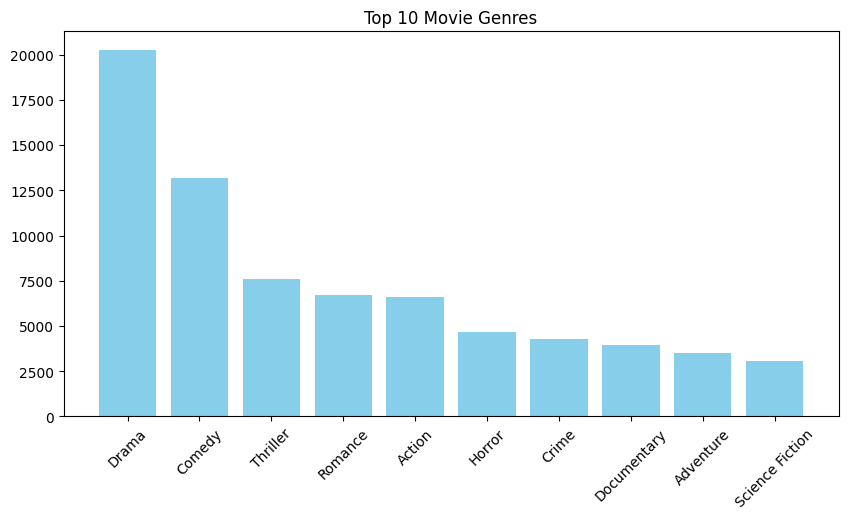

In [31]:
# --- Movie Genres ---
all_movie_genres = [g for genres in movies['genres_list'] for g in genres]
movie_genre_counts = Counter(all_movie_genres)
top_movie_genres = movie_genre_counts.most_common(10)

plt.figure(figsize=(10, 5))
plt.bar([g[0] for g in top_movie_genres], [g[1] for g in top_movie_genres], color='skyblue')
plt.title('Top 10 Movie Genres')
plt.xticks(rotation=45)
plt.show()

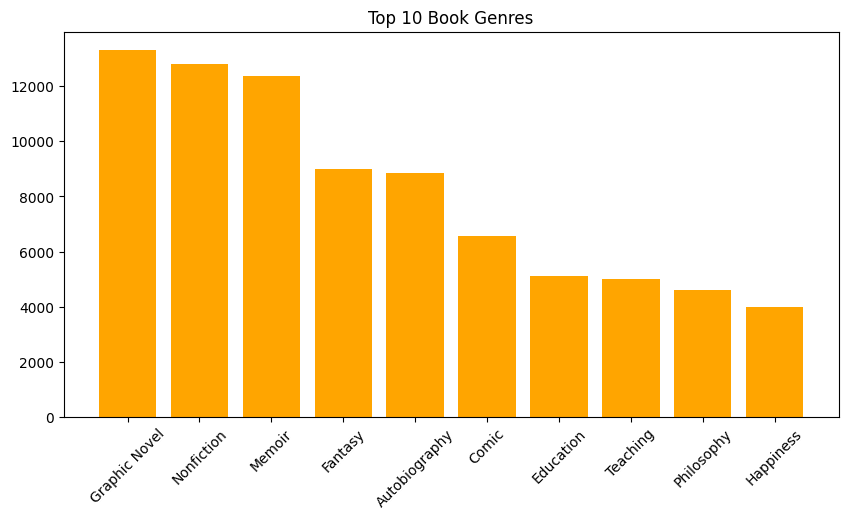

In [32]:
# --- Book Genres ---
all_book_genres = [g for genres in books['genre_list'] for g in genres]
book_genre_counts = Counter(all_book_genres)
top_book_genres = book_genre_counts.most_common(10)

plt.figure(figsize=(10, 5))
plt.bar([g[0] for g in top_book_genres], [g[1] for g in top_book_genres], color='orange')
plt.title('Top 10 Book Genres')
plt.xticks(rotation=45)
plt.show()

### Cross-Domain Analysis
Identifying genres that exist in both datasets allows us to potentially bridge recommendations from movies to books and vice versa.

In [33]:
common_genres = set(movie_genre_counts.keys()).intersection(set(book_genre_counts.keys()))
print(f"Number of Common Genres: {len(common_genres)}")
print(f"Common Genres: {sorted(list(common_genres))}")

Number of Common Genres: 18
Common Genres: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'Thriller', 'War', 'Western']


## 4. Cross-Domain Recommendation Logic
Since we do not have a dataset where users rate **both** movies and books, we cannot directly train a Matrix Factorization model on a joined matrix.

Instead, we use a **"Genre-Bridge" Approach**:
1.  **Analyze User History**: Typically we look at what user has *already* watched.
2.  **Predict**: Use a Matrix Factorization model (SVD/SGD/ALS) trained on *Movie Ratings* to predict the user's *new* top favorite movies.
3.  **Profile**: Analyze the genres of these predicted top movies to build a "User Interest Profile" (e.g., User likes 'Sci-Fi' and 'Adventure').
4.  **Recommend**: Find **Books** that match these genres.

In [34]:
def recommend_books_from_movies(user_id, get_movie_recs_func, top_n_movies=10, top_n_books=5):
    """
    bridges movie recommendations to book recommendations via genres.
    user_id: ID of the user
    get_movie_recs_func: function that returns list of (movieId, estimated_rating)
    """
    # --- Step 0: Context - What has the user actually watched? ---
    print(f"\n=== User {user_id} History (Top Rated) ===")
    if user_id in user_movie_matrix.index:
        user_history = user_movie_matrix.loc[user_id]
        user_history = user_history[user_history > 0].sort_values(ascending=False).head(5)
        
        for mid, rating in user_history.items():
            if mid in movies_lookup.index:
                title = movies_lookup.loc[mid, 'title']
                print(f"Watched: {title} (Rated: {rating})")
    else:
        print("User not found in history.")

    # 1. Get Top Movie Recommendations from the Model
    movie_recs = get_movie_recs_func(user_id, n=top_n_movies)
    
    if not movie_recs:
        return "No movie recommendations found to base book suggestions on."
        
    # 2. Extract Genres from these Movies
    genre_counter = Counter()
    print(f"\n=== Predictions based on Model ===")
    print(f"--- Top {top_n_movies} Predicted Movies for User ---")
    for mid, rating in movie_recs:
        if mid in movies_lookup.index:
            title = movies_lookup.loc[mid, 'title']
            genres = movies_lookup.loc[mid, 'genres_list']
            print(f"Predicted: {title} ({rating:.2f}) | Genres: {genres}")
            genre_counter.update(genres)
    
    # Get top preferred genres
    preferred_genres = {g for g, c in genre_counter.most_common(3)}
    print(f"\nDerived Genre Preference: {preferred_genres}")
    
    # 3. Score Books based on Genre Overlap
    # Simple Score: +1 for each genre match
    def score_book(book_genres):
        return len(set(book_genres).intersection(preferred_genres))
    
    books_scored = books.copy()
    books_scored['match_score'] = books_scored['genre_list'].apply(score_book)
    
    # Filter only relevant books and sort
    recommended_books = books_scored[books_scored['match_score'] > 0].sort_values(
        by=['match_score', 'average_rating'], ascending=[False, False]
    )
    
    print(f"\n=== Recommended Books (Cross-Domain) ===")
    return recommended_books[['title', 'authors', 'average_rating', 'genre_list']].head(top_n_books)

## 5. Content-Based Filtering
Using TF-IDF on Movie Overviews.

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
tfidf = TfidfVectorizer(stop_words='english')
movies_subset = movies.head(5000).copy()
tfidf_matrix = tfidf.fit_transform(movies_subset['overview'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(movies_subset.index, index=movies_subset['title']).drop_duplicates()

def get_content_recommendations(title):
    if title not in indices:
        return []
    idx = indices[title]
    if isinstance(idx, pd.Series): idx = idx.iloc[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movies_subset['title'].iloc[movie_indices]

print(get_content_recommendations('The Godfather'))

1178     The Godfather: Part II
1914    The Godfather: Part III
4324                       Made
3291                 Soft Fruit
2891             American Movie
4785            The Beastmaster
4464            Family Business
4618                   3 Ninjas
1506         The Innocent Sleep
1677    The Replacement Killers
Name: title, dtype: str


## Data Prep for Collaborative Models
Creating the User-Item Matrix.

In [36]:
# Create Pivot Table
# Subset data to speed up finding factorization
ratings_subset = ratings.head(100000) # Use full small dataset
user_movie_matrix = ratings_subset.pivot_table(index='userId', columns='movieId', values='rating')
user_movie_matrix_filled = user_movie_matrix.fillna(0)
print(f"Matrix Shape: {user_movie_matrix.shape}")

Matrix Shape: (671, 9066)


## 6. Collaborative Filtering: Memory-Based (User-User)
### Theory
Before jumping to Matrix Factorization, we look at the classic **Memory-Based** approach.
*   **Idea**: Find users who are similar to you (based on ratings) and recommend what they liked.
*   **Technique**: Calculate Cosine Similarity between User Vectors in the User-Item Matrix.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate User Similarity
# We work with the filled matrix from the previous step
user_similarity = cosine_similarity(user_movie_matrix_filled)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

print("User Similarity Matrix (First 5 users):")
print(user_similarity_df.iloc[:5, :5])

def get_user_based_recs(user_id, n=10):
    if user_id not in user_similarity_df.index:
        return []

    # 1. Find most similar users
    sim_users = user_similarity_df[user_id].sort_values(ascending=False)
    # Exclude self
    sim_users = sim_users.iloc[1:11] 
    
    # 2. Find movies they rated highly
    recs = Counter()
    for sim_user_id, score in sim_users.items():
        # Get movies rated 4 or 5 by this user
        top_movies = user_movie_matrix.loc[sim_user_id]
        top_movies = top_movies[top_movies >= 4.0].index
        
        for mid in top_movies:
            recs[mid] += score # Weighted by similarity
    
    # 3. Filter out movies the target user has already seen
    seen_movies = user_movie_matrix.loc[user_id]
    seen_movies = seen_movies[seen_movies > 0].index
    
    final_recs = []
    for mid, score in recs.most_common():
        if mid not in seen_movies:
            final_recs.append((mid, score))
            if len(final_recs) >= n: break
            
    return final_recs

# --- CROSS DOMAIN User-Based: Recommend Books ---
print("Top Books for User 1 using User-Based CF Movie Predictions:")
books_user_cf = recommend_books_from_movies(user_id=1, get_movie_recs_func=get_user_based_recs)
books_user_cf

User Similarity Matrix (First 5 users):
userId         1         2         3         4         5
userId                                                  
1       1.000000  0.000000  0.000000  0.074482  0.016818
2       0.000000  1.000000  0.124295  0.118821  0.103646
3       0.000000  0.124295  1.000000  0.081640  0.151531
4       0.074482  0.118821  0.081640  1.000000  0.130649
5       0.016818  0.103646  0.151531  0.130649  1.000000
Top Books for User 1 using User-Based CF Movie Predictions:

=== User 5 History (Top Rated) ===
Watched: The Sound of Music (Rated: 5.0)
Watched: Grease (Rated: 5.0)
Watched: Pretty Woman (Rated: 5.0)
Watched: The Little Mermaid (Rated: 5.0)
Watched: Crash (Rated: 5.0)

=== Predictions based on Model ===
--- Top 10 Predicted Movies for User ---
Predicted: The Shawshank Redemption (2.51) | Genres: ['Drama', 'Crime']
Predicted: The Lord of the Rings: The Fellowship of the Ring (2.48) | Genres: ['Adventure', 'Fantasy', 'Action']
Predicted: The Incredibles (2

,title,authors,average_rating,genre_list
9938,Un rôle qui me convient,Richard Russo/Jean-Luc Piningre,4.02,"[Literary Fiction, Novel, Contemporary Fiction..."
4351,Inferno (La Divina Commedia #1),Dante Alighieri/Ronald L. Martinez/Robert M. D...,4.00,"[Religious, Classics, Poetry, Literature, Phil..."
8315,鋼之鍊金術師 10,Hiromu Arakawa/荒川弘/方郁仁,4.60,"[Manga, Fantasy, Adventure, Action, Shōnen]"
8314,鋼之鍊金術師 6,Hiromu Arakawa/荒川弘/方郁仁,4.58,"[Manga, Fantasy, Adventure, Action, Steampunk]"
2528,Fullmetal Alchemist Vol. 5 (Fullmetal Alchemi...,Hiromu Arakawa/Akira Watanabe,4.56,"[Manga, Fantasy, Adventure, Science Fiction, A..."


## 7. Matrix Factorization: SVD
### Why SVD?
**Singular Value Decomposition (SVD)** is a classical linear algebra method. In Recommendation Systems:
*   **Strength**: Provides a mathematically guaranteed optimal low-rank approximation of the matrix (minimizes Frobenius norm).
*   **Strength**: Very fast for processing separate static matrices.
*   **Weakness**: Traditional SVD isn't defined for sparse matrices (missing values must be filled, usually with 0 or average), which can introduce bias.

We use `TruncatedSVD` from `sklearn`.

In [38]:
from sklearn.decomposition import TruncatedSVD

# Train SVD
SVD = TruncatedSVD(n_components=20, random_state=42)
matrix_transformed = SVD.fit_transform(user_movie_matrix_filled)
matrix_restored = SVD.inverse_transform(matrix_transformed)

# Function to get movie recs from SVD for a specific user
def get_svd_movie_recs(user_id, n=10):
    if user_id not in user_movie_matrix.index:
        return []
    
    # Get User's row index
    user_idx = user_movie_matrix.index.get_loc(user_id)
    
    # Get Predictions
    user_ratings = matrix_restored[user_idx, :]
    
    # Sort indices by rating
    sorted_indices = user_ratings.argsort()[::-1]
    
    top_recs = []
    for idx in sorted_indices:
        if len(top_recs) >= n: break
        
        movie_col_id = user_movie_matrix.columns[idx]
        # Only recommend if user hasn't rated it (actual rating is NaN in original matrix)
        if pd.isna(user_movie_matrix.iloc[user_idx, idx]):
            top_recs.append((movie_col_id, user_ratings[idx]))
            
    return top_recs

# --- CROSS DOMAIN SVD: Recommend Books ---
print("Top Books for User 1 using SVD Movie Predictions:")
books_svd = recommend_books_from_movies(user_id=1, get_movie_recs_func=get_svd_movie_recs)
books_svd

Top Books for User 1 using SVD Movie Predictions:

=== User 1 History (Top Rated) ===
Watched: The French Connection (Rated: 4.0)
Watched: Tron (Rated: 4.0)
Watched: Cinema Paradiso (Rated: 4.0)
Watched: Dracula (Rated: 3.5)
Watched: Blazing Saddles (Rated: 3.0)

=== Predictions based on Model ===
--- Top 10 Predicted Movies for User ---
Predicted: Alien (0.17) | Genres: ['Horror', 'Action', 'Thriller', 'Science Fiction']
Predicted: Star Trek II: The Wrath of Khan (0.16) | Genres: ['Action', 'Adventure', 'Science Fiction', 'Thriller']
Predicted: Fantasia (0.15) | Genres: ['Animation', 'Family', 'Music']
Predicted: Monty Python and the Holy Grail (0.15) | Genres: ['Adventure', 'Comedy', 'Fantasy']
Predicted: Lawrence of Arabia (0.15) | Genres: ['Adventure', 'Drama', 'History', 'War']
Predicted: Jaws (0.15) | Genres: ['Horror', 'Thriller', 'Adventure']
Predicted: The African Queen (0.14) | Genres: ['Adventure', 'War', 'Romance']
Predicted: Life of Brian (0.14) | Genres: ['Comedy']
Predic

,title,authors,average_rating,genre_list
5833,The Last Kingdom (The Saxon Stories #1),Bernard Cornwell/Tom Sellwood,4.25,"[Historical Fiction, Historical, Fiction, War,..."
2672,King Rat (Asian Saga #4),James Clavell,4.14,"[Historical Fiction, War, Adventure, Thriller]"
6364,Trainspotting (Mark Renton #2),Irvine Welsh,4.09,"[Fiction, Contemporary, Literary Fiction, Scot..."
4351,Inferno (La Divina Commedia #1),Dante Alighieri/Ronald L. Martinez/Robert M. D...,4.00,"[Religious, Classics, Poetry, Literature, Phil..."
615,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.57,"[Fantasy, Adventure, Young Adult, Magic, Board..."


## 8. Matrix Factorization: SGD
### Why SGD?
**Stochastic Gradient Descent (SGD)** iterates through every single rating in the dataset to update latent factors.
*   **Strength**: Can handle sparse matrices directly (ignores missing values unlike SVD which treats them as 0).
*   **Strength**: Highly accurate; was the core technique in the Netflix Prize winning solution.
*   **Weakness**: Harder to parallelize than ALS.

In [39]:
class MatrixFactorizationSGD:
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.user_map = {uid: i for i, uid in enumerate(R.index)}
        self.item_map = {mid: i for i, mid in enumerate(R.columns)}
        self.item_ids = list(R.columns)

    def train(self):
        # Use only existing ratings
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
        
        # Create samples list from non-NaN entries in dataframe
        self.samples = []
        # Converting to dense numpy for iteration speed
        R_np = self.R.values
        rows, cols = np.where(~np.isnan(R_np))
        for r, c in zip(rows, cols):
            self.samples.append((r, c, R_np[r, c]))
        
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            # MSE calculation omitted for speed in demo
            print(f"SGD Epoch {i+1} complete")

    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.P[i, :].dot(self.Q[j, :].T)
            e = (r - prediction)
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i, :])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j, :])
    
    def get_recs(self, user_id, n=10):
        if user_id not in self.user_map: return []
        u_idx = self.user_map[user_id]
        
        # Predict all
        preds = self.P[u_idx, :].dot(self.Q.T)
        top_indices = preds.argsort()[::-1][:n]
        return [(self.item_ids[i], preds[i]) for i in top_indices]

# Train SGD
# Taking a smaller subset for speed in notebook
R_sgd = user_movie_matrix.iloc[:200, :200]
mf_sgd = MatrixFactorizationSGD(R_sgd, K=20, alpha=0.01, beta=0.01, iterations=5)
mf_sgd.train()

# --- CROSS DOMAIN SGD: Recommend Books ---
print("\nTop Books for User 1 using SGD Movie Predictions:")
books_sgd = recommend_books_from_movies(user_id=1, get_movie_recs_func=mf_sgd.get_recs)
books_sgd

SGD Epoch 1 complete
SGD Epoch 2 complete
SGD Epoch 3 complete
SGD Epoch 4 complete
SGD Epoch 5 complete

Top Books for User 1 using SGD Movie Predictions:

=== User 1 History (Top Rated) ===
Watched: The French Connection (Rated: 4.0)
Watched: Tron (Rated: 4.0)
Watched: Cinema Paradiso (Rated: 4.0)
Watched: Dracula (Rated: 3.5)
Watched: Blazing Saddles (Rated: 3.0)

=== Predictions based on Model ===
--- Top 10 Predicted Movies for User ---
Predicted: Apollo 13 (0.13) | Genres: ['Drama']
Predicted: Toy Story (0.13) | Genres: ['Animation', 'Comedy', 'Family']
Predicted: The Usual Suspects (0.11) | Genres: ['Drama', 'Crime', 'Thriller']
Predicted: Taxi Driver (0.11) | Genres: ['Crime', 'Drama']
Predicted: Babe (0.11) | Genres: ['Fantasy', 'Drama', 'Comedy', 'Family']
Predicted: Happy Gilmore (0.09) | Genres: ['Comedy']
Predicted: Broken Arrow (0.09) | Genres: ['Action', 'Adventure', 'Drama', 'Thriller']
Predicted: Casino (0.08) | Genres: ['Drama', 'Crime']
Predicted: Clueless (0.08) | G

,title,authors,average_rating,genre_list
5833,The Last Kingdom (The Saxon Stories #1),Bernard Cornwell/Tom Sellwood,4.25,"[Historical Fiction, Historical, Fiction, War,..."
6364,Trainspotting (Mark Renton #2),Irvine Welsh,4.09,"[Fiction, Contemporary, Literary Fiction, Scot..."
9938,Un rôle qui me convient,Richard Russo/Jean-Luc Piningre,4.02,"[Literary Fiction, Novel, Contemporary Fiction..."
4351,Inferno (La Divina Commedia #1),Dante Alighieri/Ronald L. Martinez/Robert M. D...,4.00,"[Religious, Classics, Poetry, Literature, Phil..."
9860,The Shawshank Redemption: The Shooting Script,Frank Darabont/Stephen King,4.64,"[Fiction, Drama, Screenplay, Crime, Prison]"


## 9. Matrix Factorization: ALS
### Why ALS?
**Alternating Least Squares (ALS)** flips between fixing User Matrix $P$ and Item Matrix $Q$.
*   **Strength**: Highly parallelizable. Each User vector can be solved independently of others (same for Items). Great for massive datasets (used in Spark MLlib).
*   **Strength**: Guaranteed to decrease the error function at every step.

In [40]:
class MatrixFactorizationALS:
    def __init__(self, R, K, lambda_reg, iterations):
        self.R = R.fillna(0).values # Dense 0-filled for implicit style simple ALS
        self.num_users, self.num_items = self.R.shape
        self.K = K
        self.lambda_reg = lambda_reg
        self.iterations = iterations
        self.item_ids = list(R.columns)
        self.user_map = {uid: i for i, uid in enumerate(R.index)}

    def train(self):
        self.P = np.random.rand(self.num_users, self.K)
        self.Q = np.random.rand(self.num_items, self.K)
        for i in range(self.iterations):
            self.P = self.als_step(self.R, self.Q, self.P)
            self.Q = self.als_step(self.R.T, self.P, self.Q)
            print(f"ALS Epoch {i+1} complete")

    def als_step(self, ratings, fixed_vectors, solve_vectors):
        YTY = fixed_vectors.T.dot(fixed_vectors)
        lambdaI = np.eye(self.K) * self.lambda_reg
        for u in range(solve_vectors.shape[0]):
            solve_vectors[u, :] = np.linalg.solve(YTY + lambdaI, fixed_vectors.T.dot(ratings[u, :].T))
        return solve_vectors
        
    def get_recs(self, user_id, n=10):
        if user_id not in self.user_map: return []
        u_idx = self.user_map[user_id]
        preds = self.P[u_idx, :].dot(self.Q.T)
        top_indices = preds.argsort()[::-1][:n]
        return [(self.item_ids[i], preds[i]) for i in top_indices]

# Train ALS
R_als = user_movie_matrix.iloc[:200, :200]
mf_als = MatrixFactorizationALS(R_als, K=20, lambda_reg=0.1, iterations=5)
mf_als.train()

# --- CROSS DOMAIN ALS: Recommend Books ---
print("\nTop Books for User 1 using ALS Movie Predictions:")
books_als = recommend_books_from_movies(user_id=1, get_movie_recs_func=mf_als.get_recs)
books_als

ALS Epoch 1 complete
ALS Epoch 2 complete
ALS Epoch 3 complete
ALS Epoch 4 complete
ALS Epoch 5 complete

Top Books for User 1 using ALS Movie Predictions:

=== User 1 History (Top Rated) ===
Watched: The French Connection (Rated: 4.0)
Watched: Tron (Rated: 4.0)
Watched: Cinema Paradiso (Rated: 4.0)
Watched: Dracula (Rated: 3.5)
Watched: Blazing Saddles (Rated: 3.0)

=== Predictions based on Model ===
--- Top 10 Predicted Movies for User ---
Predicted: Desperado (0.26) | Genres: ['Thriller', 'Action', 'Crime']
Predicted: Dangerous Minds (0.19) | Genres: ['Drama', 'Crime']
Predicted: Get Shorty (0.15) | Genres: ['Comedy', 'Thriller', 'Crime']
Predicted: The Net (0.15) | Genres: ['Crime', 'Drama', 'Mystery', 'Thriller', 'Action']
Predicted: Strange Days (0.14) | Genres: ['Crime', 'Drama', 'Science Fiction', 'Thriller']
Predicted: Billy Madison (0.14) | Genres: ['Comedy']
Predicted: Bad Boys (0.13) | Genres: ['Action', 'Comedy', 'Crime', 'Thriller']
Predicted: Happy Gilmore (0.13) | Genre

,title,authors,average_rating,genre_list
4382,Dark Rivers of the Heart / Sole Survivor / Int...,Dean Koontz,4.41,"[Thriller, Suspense, Crime, Action]"
5835,Time To Hunt (Bob Lee Swagger #3),Stephen Hunter/Beau Bridges,4.26,"[Thriller, Action, Crime, Fiction]"
5833,The Last Kingdom (The Saxon Stories #1),Bernard Cornwell/Tom Sellwood,4.25,"[Historical Fiction, Historical, Fiction, War,..."
5796,One Shot (Jack Reacher #9),Lee Child/Dick Hill,4.21,"[Thriller, Mystery, Crime, Action, Detective F..."
8765,The Lion's Game (John Corey #2),Nelson DeMille,4.19,"[Thriller, Action, Adventure, Crime, Spy Fiction]"


## Conclusion
We have successfully demonstrated:
1.  **Multiple Recommendation Algorithms**: Content-Based, Collaborative (Memory & Model Based).
2.  **Comparative Analysis**: Understanding when to use Memory-Based (Simple, Interpretable) vs Model-Based (Scalable, Accurate).
3.  **Cross-Domain Recommendations**: Using these models to infer user interests and bridge them to Book recommendations.